# Create Access To Grocery Stores Map throughout Toronto

Using the hexagonal grid, created in `1-- create_hexagonal_grid.ipynb`, and the supermarkets from the DineSafe open data, created in `2--read_DineSafe_opendata.ipynb`, calculate travel times to third closest grocery stores throughout Toronto.

In [ ]:
from datetime import datetime, timedelta
import geopandas as gpd
from pathlib import Path

from accessto.access_opportunities import nth_closest_opportunity
from accessto.r5py_travel_time_computer import R5PYTravelTimeComputer

## Inputs

In [ ]:
root_dir = Path(r"C:\Access To Opportunities")
data_root_dir = root_dir / "Data"
network_dir = root_dir / "Network"
working_dir = root_dir / "working"

dinesafe_fp = working_dir / "dinesafe_supermarkets.shp"
hex_polygons_fp = working_dir / "hex_polgns_final.shp"
hex_pts_fp = working_dir / "hex_pts_final.shp"


wgs84_proj_str = "EPSG:4326"
cot_proj_str = "EPSG:2952"

## Read processed supermarkets and hex grid

In [ ]:
# Read processed DineSafe supermarket data
supermarkets = gpd.read_file(dinesafe_fp, engine="pyogrio")

In [ ]:
# Read hexagonal grid representative points, and polygons
hex_polygons = gpd.read_file(hex_polygons_fp, engine="pyogrio")
hex_pts = gpd.read_file(hex_pts_fp, engine="pyogrio")

## Calculate transit travel time matrix using r5py

In this section:
1. calculate travel time matrix to grocery stores for an 11-hour interval starting at 9:00 in the morning.
2. calculate travel time matrix from grocery stores, this is the return trip. Keep same interval
3. take the average

Note that due to the number of cells, this computation can take a while. If you want to speed it up, you can try
rerunning the `1-- create_hexagonal_grid.ipynb` with a coarser resolution with an increment of, say, 1000 metres.

In [ ]:
r5py_ttc = R5PYTravelTimeComputer()

In [ ]:
r5py_ttc.build_network_from_dir(network_dir)

In [ ]:
ttm_to_groc = r5py_ttc.compute_transit_traveltime_matrix(
    origins=hex_pts,
    destinations=supermarkets,
    departure=datetime(2022, 11, 10, 9, 0, 0),
    departure_time_window=timedelta(hours=11),
    speed_walking=5.0,
    max_time=timedelta(hours=1)
)

In [ ]:
ttm_from_groc = r5py_ttc.compute_transit_traveltime_matrix(
    origins=supermarkets,
    destinations=hex_pts,
    departure=datetime(2022, 11, 10, 9, 0, 0),
    departure_time_window=timedelta(hours=11),
    speed_walking=5.0,
    max_time=timedelta(hours=1)
)

### Find the average travel time

In [ ]:
# Merge the two travel time matrices together by the from and to ids, then calculate the average.
ttm_merged = ttm_to_groc.merge(ttm_from_groc, left_on=['from_id', 'to_id'], right_on=['to_id', 'from_id'], suffixes=['', '_y'])
ttm_merged['travel_time'] = ttm_merged[['travel_time', 'travel_time_y']].mean(axis=1)

# Cleanup temporary columns
ttm_merged = ttm_merged.drop(['from_id_y', 'to_id_y', 'travel_time_y'], axis=1)

In [ ]:
# Fill in NaNs with a large number
# These NaNs occur because we capped the travel time at 1 hour to reduce computation time
ttm_merged['travel_time'] = ttm_merged['travel_time'].fillna(99999.99)

# Calculate the travel time to the third-closest store

In [ ]:
third_closest = nth_closest_opportunity(ttm_merged, n=3)
third_closest.name = "third_cl"

# Merge access data back into the polygons shapefile for display

In [ ]:
hex_polgns_final = hex_polygons.merge(third_closest, how='left', left_on='id', right_on='from_id')
hex_polgns_final.to_file(working_dir / "hex_withtraveltimes.shp", index=False)

Here's an image of the completed travel times to third-closest grocery stores.

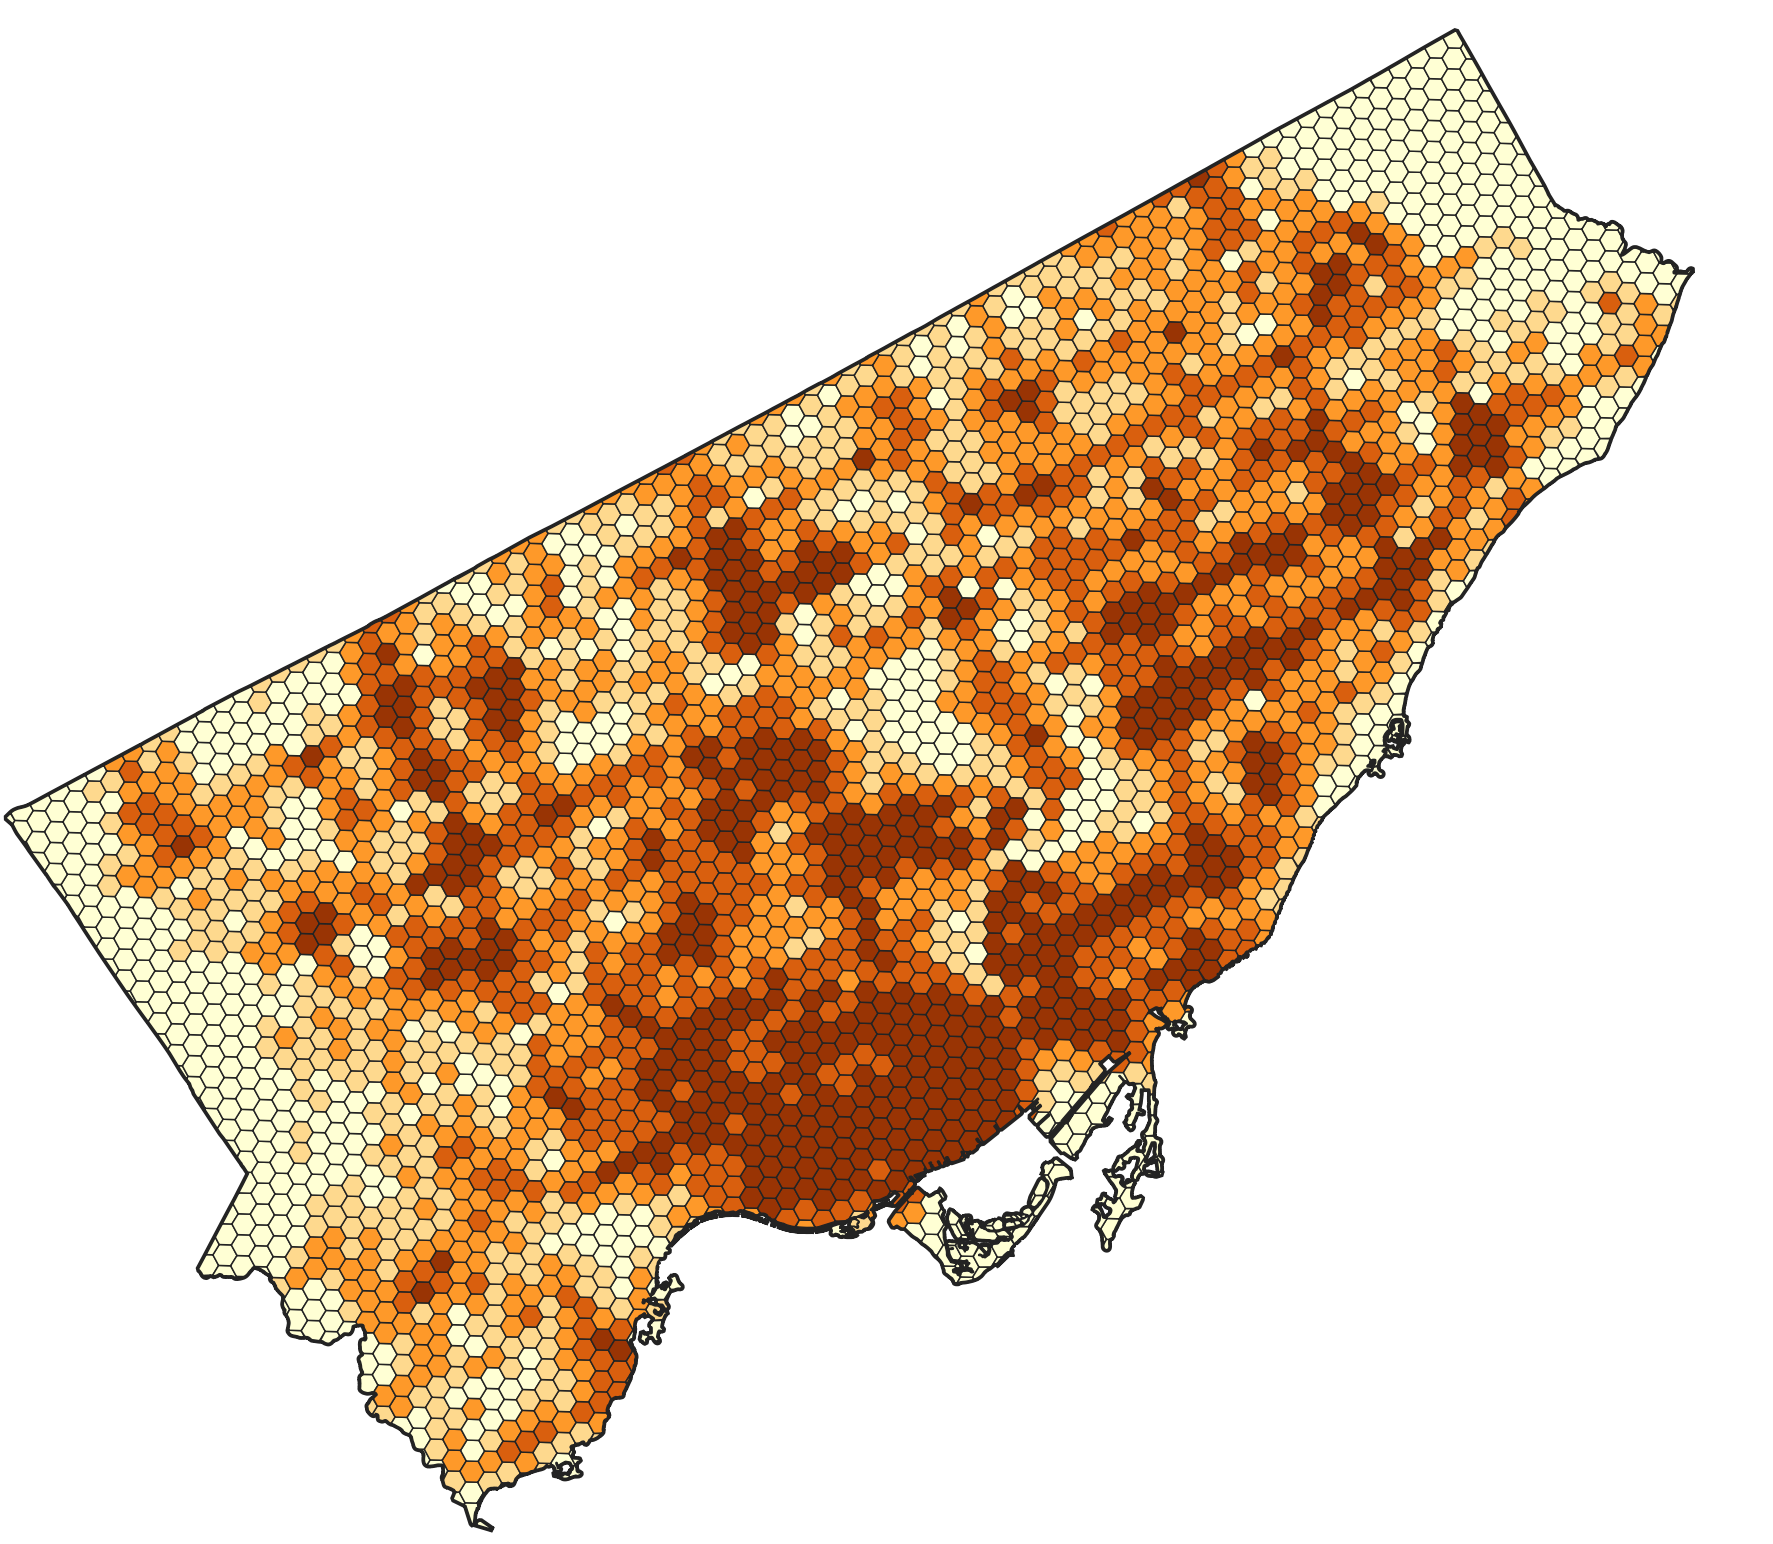